In [0]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

# Data Handling
import pandas as pd

# Visualisation
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow for regression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [180]:
df = pd.read_csv('diamonds.csv')
diamondData = df.copy()
diamondData.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [181]:
diamondData = diamondData.drop(['Unnamed: 0'], axis=1)
diamondData.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


1.   You can see that the min values of **x, y and z are 0** which is practically impossible. These are the missing values and have to be discarded
2.   **Categorical Features** : cut, color, clarity
3. **Numerical Feature** : carat, depth, table, x, y, z, price



In [0]:
# Remove the rows that have x, y , z equal to zero
diamondData = diamondData[(diamondData[['x', 'y', 'z']] != 0).all(axis=1)]

# Use x,y,z to create a sythetic feature -- volume
diamondData['volume'] = diamondData['x'] * diamondData['y'] *diamondData['z']
# diamondData['carat_volume'] = diamondData['volume'] * diamondData['carat']

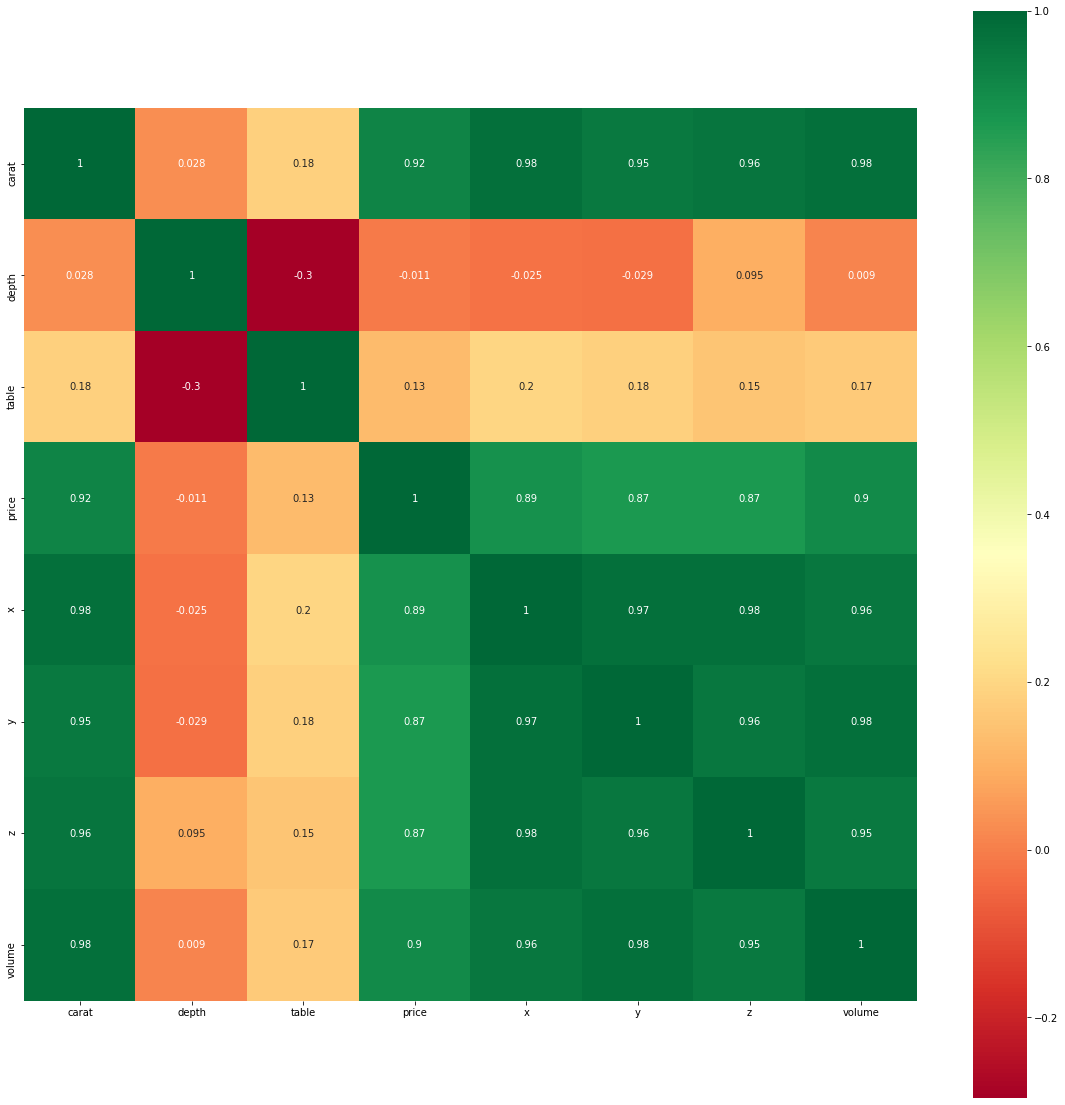

In [183]:
# Correlation Map
plt.figure(figsize=(20,20))
corr = diamondData.corr()
sns.heatmap(data=corr, square=True, annot=True, cmap='RdYlGn')

From the above correlation map we can see that carat, x, y, z have better correlation with price.


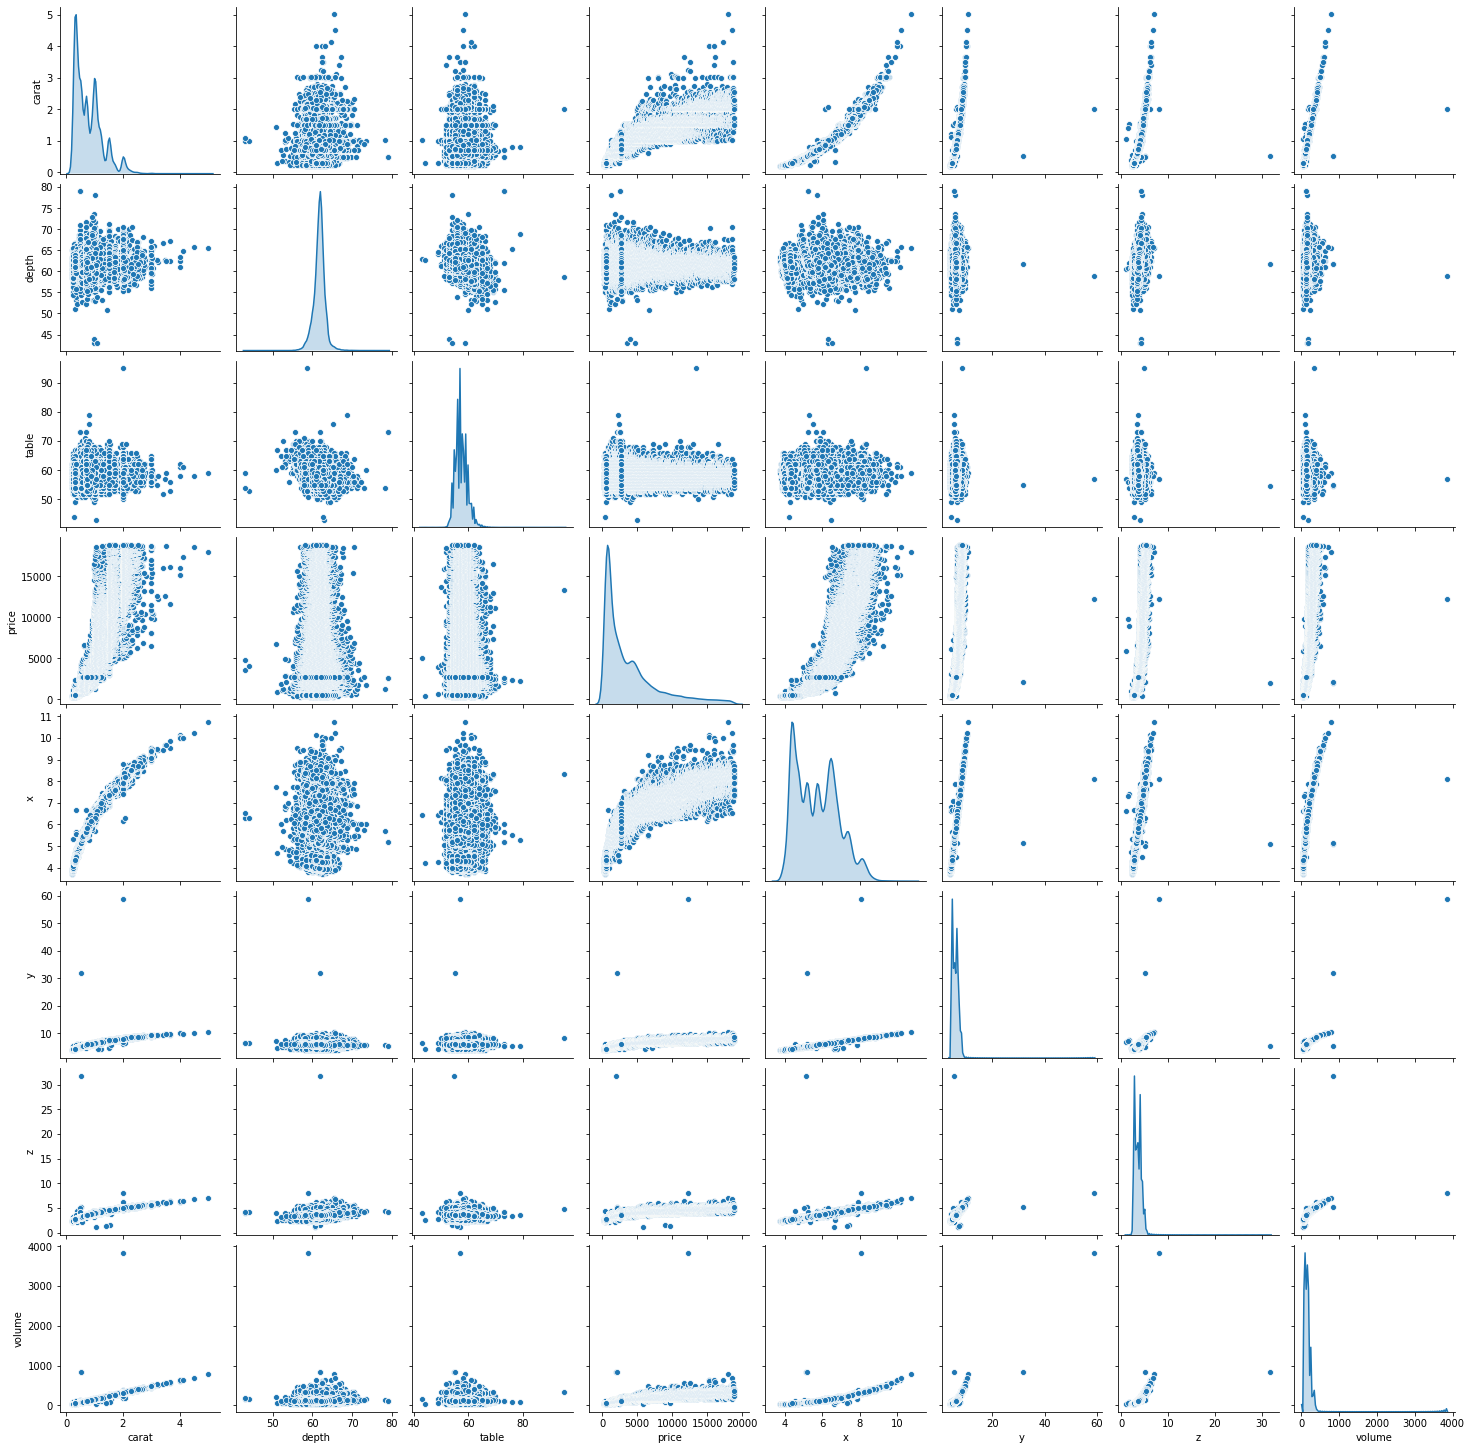

In [184]:
#pairplotting all the features
sns.pairplot(diamondData, diag_kind="kde")

In [185]:
# Check for NaN
diamondData.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
volume     0
dtype: int64

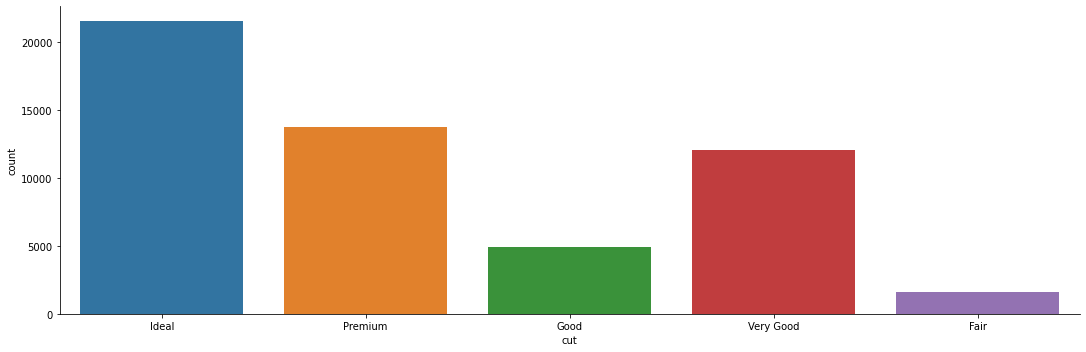

In [186]:
sns.factorplot(x='cut', data=diamondData , kind='count', aspect= 3)

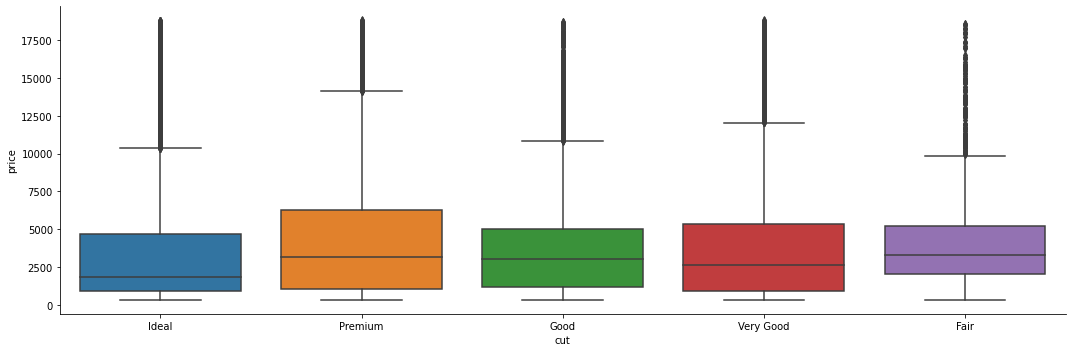

In [187]:
sns.factorplot(x='cut', y='price',data=diamondData , kind='box', aspect= 3)

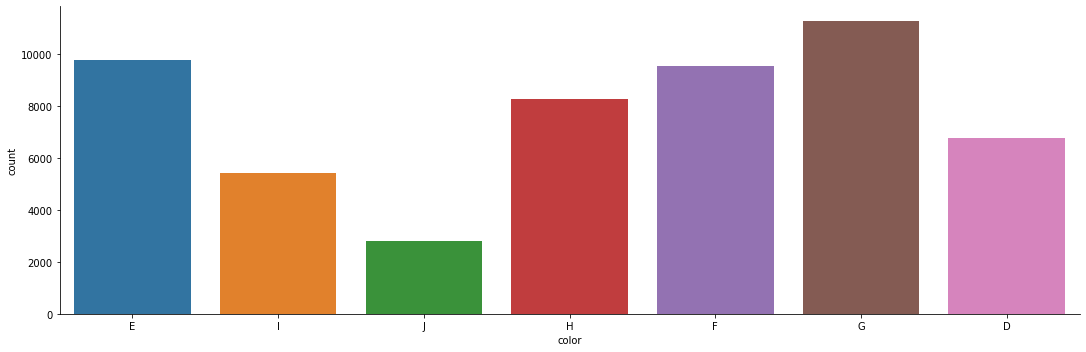

In [188]:
sns.factorplot(x='color', data=diamondData , kind='count', aspect= 3)

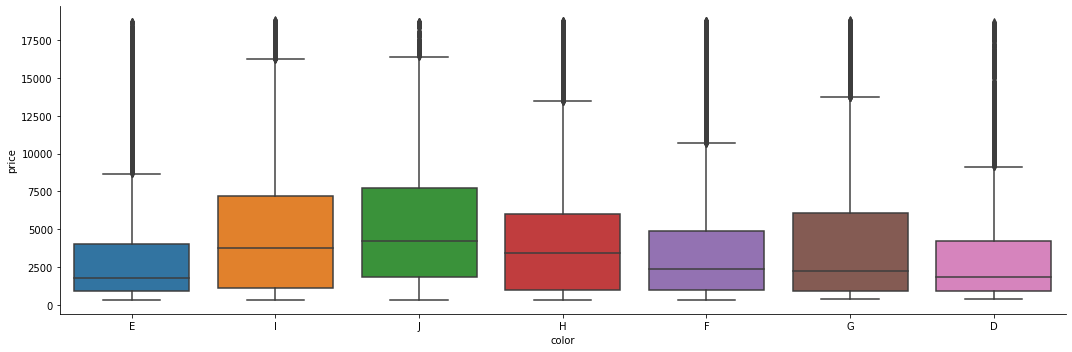

In [189]:
sns.factorplot(x='color', y='price',data=diamondData , kind='box', aspect= 3)

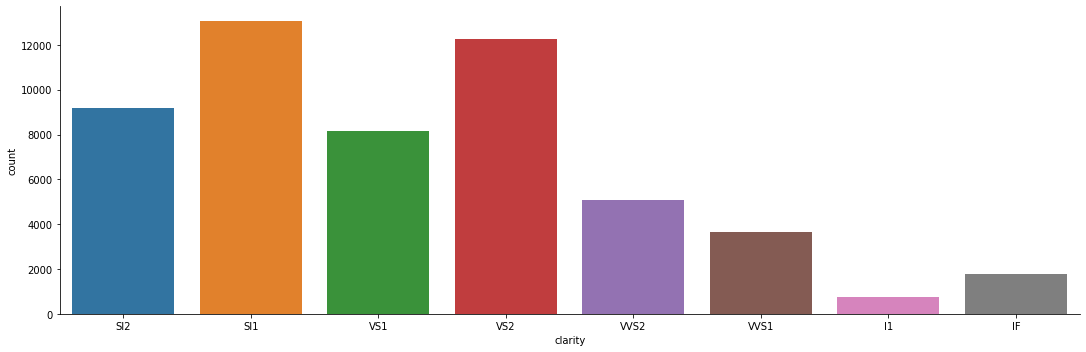

In [190]:
sns.factorplot(x='clarity', data=diamondData , kind='count', aspect= 3)

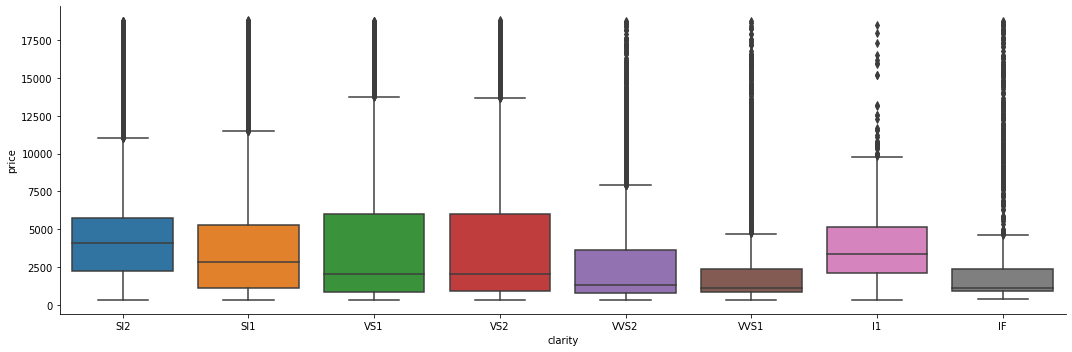

In [191]:
sns.factorplot(x='clarity', y='price',data=diamondData , kind='box', aspect= 3)

In [192]:
#One-Hot Encoding for Categorical columns
diamondFeaturesDF =  pd.get_dummies(diamondData)

# Dropping depth , table due to lack of corelation with price
# Dropping x, y, z due to having intercorelation with each other
diamondFeaturesDF = diamondFeaturesDF.drop(columns=['depth', 'table', 'x', 'y', 'z'])
diamondFeaturesDF

,carat,price,volume,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,326,38.202030,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,326,34.505856,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,327,38.076885,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,334,46.724580,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0.31,335,51.917250,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,2757,115.920000,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
53936,0.72,2757,118.110175,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
53937,0.70,2757,114.449728,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
53938,0.86,2757,140.766120,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [0]:
# Divide the dataset to train and test sets
train_dataset = diamondFeaturesDF.sample(frac=0.8,random_state=0)
test_dataset = diamondFeaturesDF.drop(train_dataset.index)

#Take out the labels
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

# Z-score Normalization
train_dataset_normalized = (train_dataset - train_dataset.mean())/train_dataset.std()
test_dataset_normalized = (test_dataset - test_dataset.mean())/test_dataset.std()

In [216]:
train_dataset_normalized.head()

,carat,volume,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
15190,1.043455,1.038796,-0.176764,-0.313313,-0.818050,-0.58591,1.862164,-0.379441,-0.469712,-0.464483,-0.515014,-0.425777,2.982176,-0.233593,-0.118766,-0.184899,-0.561458,-0.452448,-0.424028,1.843965,-0.269406,-0.326043
36022,-0.943998,-0.907064,-0.176764,-0.313313,1.222391,-0.58591,-0.536997,-0.379441,2.128915,-0.464483,-0.515014,-0.425777,-0.335318,-0.233593,-0.118766,-0.184899,-0.561458,-0.452448,-0.424028,1.843965,-0.269406,-0.326043
7689,0.218873,0.255965,-0.176764,-0.313313,-0.818050,-0.58591,1.862164,-0.379441,-0.469712,-0.464483,1.941652,-0.425777,-0.335318,-0.233593,-0.118766,-0.184899,-0.561458,-0.452448,-0.424028,1.843965,-0.269406,-0.326043
34158,-0.986284,-0.957702,-0.176764,-0.313313,1.222391,-0.58591,-0.536997,-0.379441,-0.469712,-0.464483,1.941652,-0.425777,-0.335318,-0.233593,-0.118766,-0.184899,-0.561458,-0.452448,2.358278,-0.542297,-0.269406,-0.326043
19285,0.430304,0.398650,-0.176764,-0.313313,-0.818050,-0.58591,1.862164,-0.379441,-0.469712,2.152882,-0.515014,-0.425777,-0.335318,-0.233593,-0.118766,-0.184899,-0.561458,-0.452448,-0.424028,-0.542297,3.711785,-0.326043


In [200]:
# Build a sequential model
def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu', input_shape=[len(train_dataset_normalized.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  
  return model

model = build_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 64)                1472      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


In [201]:
# Train the model
EPOCHS = 500

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3000)

history = model.fit(
  train_dataset_normalized, train_labels,
  batch_size=100, epochs=EPOCHS, validation_split = 0.3, verbose=0,
  callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:29941834.0000,  mae:3807.0642,  mse:29942212.0000,  val_loss:26865762.0000,  val_mae:3543.4026,  val_mse:26823760.0000,  
....................................................................................................
Epoch: 100, loss:472273.4375,  mae:312.1083,  mse:472312.4375,  val_loss:375024.7188,  val_mae:312.5054,  val_mse:375073.0938,  
....................................................................................................
Epoch: 200, loss:342898.0000,  mae:303.4103,  mse:342924.9062,  val_loss:350269.9375,  val_mae:307.1443,  val_mse:350225.6875,  
....................................................................................................
Epoch: 300, loss:330096.2812,  mae:298.9272,  mse:330126.4688,  val_loss:346505.6562,  val_mae:303.5508,  val_mse:346420.8125,  
....................................................................................................
Epoch: 400, loss:321026.0625,  mae:295.8355,  mse:321055.1562,  val_los

Text(0, 0.5, 'MAE [Price]')

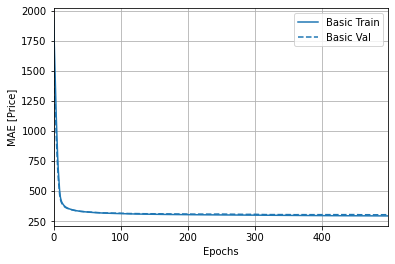

In [202]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Price]')

Text(0, 0.5, 'MSE [Price^2]')

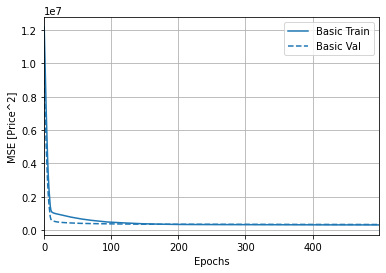

In [203]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE [Price^2]')

In [204]:
loss, mae, mse = model.evaluate(test_dataset_normalized, test_labels, verbose=2)
print("Testing set loss: {:5.2f}".format(loss))
print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Testing set Mean Sqr Error: {:5.2f}".format(mse))

337/337 - 0s - loss: 364475.0000 - mae: 328.6099 - mse: 364475.0000
Testing set loss: 364475.00
Testing set Mean Abs Error: 328.61
Testing set Mean Sqr Error: 364475.00


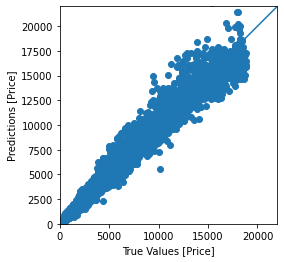

In [222]:
test_predictions = model.predict(test_dataset_normalized).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
lims = [0, 22000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

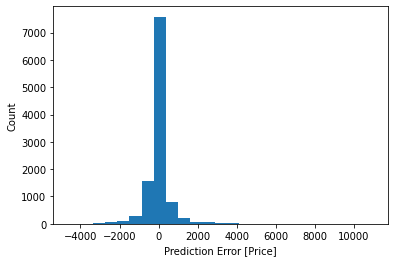

In [223]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")

In [225]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
carat,43136.0,0.796480,0.472967,0.200000,0.400000,0.700000,1.0400,4.50000
volume,43136.0,129.731226,78.521001,31.707984,65.079682,114.842962,170.8206,3840.59806
cut_Fair,43136.0,0.030300,0.171412,0.000000,0.000000,0.000000,0.0000,1.00000
cut_Good,43136.0,0.089392,0.285312,0.000000,0.000000,0.000000,0.0000,1.00000
cut_Ideal,43136.0,0.400918,0.490090,0.000000,0.000000,0.000000,1.0000,1.00000
cut_Premium,43136.0,0.255564,0.436183,0.000000,0.000000,0.000000,1.0000,1.00000
cut_Very Good,43136.0,0.223827,0.416812,0.000000,0.000000,0.000000,0.0000,1.00000
color_D,43136.0,0.125858,0.331693,0.000000,0.000000,0.000000,0.0000,1.00000
color_E,43136.0,0.180754,0.384819,0.000000,0.000000,0.000000,0.0000,1.00000
color_F,43136.0,0.177462,0.382064,0.000000,0.000000,0.000000,0.0000,1.00000


In [0]:
import pickle

with open('diamond_train_stats', 'wb') as file_pi:
    pickle.dump(train_stats, file_pi)

In [0]:
model.save('DiamondPricePredictor_model_loss-364475.h5')